# Setup

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import opt_einsum as oe
from scipy.optimize import minimize, differential_evolution, NonlinearConstraint

from quant_rotor.core.sparse.hamiltonian import hamiltonian_sparse
from quant_rotor.core.dense.hamiltonian import hamiltonian_dense
from quant_rotor.core.dense.hamiltonian_big import hamiltonian_general_dense
from quant_rotor.core.sparse.hamiltonian_big import hamiltonian_general_sparse

from quant_rotor.core.dense.de_solve_one_thermal import integration_scheme
# from quant_rotor.core.dense.de_solve_one_thermal_dense import integration_scheme as int_fast
import quant_rotor.models.dense.thermofield_boltz_funcs as bz

from quant_rotor.core.dense.t_amplitudes_periodic import t_periodic

from quant_rotor.models.dense.density_matrix import density_matrix_1

from quant_rotor.core.dense.t_amplitudes_guess import amplitute_energy

from quant_rotor.models.dense.support_ham import write_matrix_elements, basis_m_to_p_matrix_conversion

In [27]:
np.set_printoptions(precision=5)
np.set_printoptions(suppress=True)
np.set_printoptions(linewidth=np.inf)
np.set_printoptions(threshold=np.inf)

In [ ]:
site = 4
state = 3
g = 0.9

# TF Hamimltonian

In [38]:
K_2, _, _ = hamiltonian_dense(state, 2, g, periodic=False)

_, V = write_matrix_elements((state - 1) // 2)

V_tensor = V.reshape(state, state, state, state)
V_in_p = basis_m_to_p_matrix_conversion(V_tensor, state)
V_in_p = V_in_p.reshape(state**2, state**2) * g

H, K, V = hamiltonian_dense(state**2, site // 2, g, periodic=True, Double=True, Import=True, K_import=K_2, V_import=V_in_p)

In [45]:
site_1 = site
state_1 = state

site = site // 2
state = state ** 2

In [30]:
# H, K, V = hamiltonian_general_dense(state, site, g)
# H, K, V = hamiltonian_dense(state, site, g)

In [31]:
eig_val_ED, eig_vec_ED = np.linalg.eigh(H)

In [8]:
state_2 = state**2

## Check kron and change of basis

***TF in p basis.***

In [9]:
U, _ = bz.thermofield_change_of_basis(K)
I = np.eye(state)

K_tilda = bz.H_tilde_maker(K)

K_prim = oe.contract('pq,mw->pmqw', K, I,  optimize='optimal')
K_tilda_kron = U.T @ K_prim.reshape(state_2, state_2) @ U

V_prim = oe.contract('pqrs,mw,nv->pmqnrwsv', V.reshape(state, state, state, state), I, I,  optimize='optimal')
V_tilda = oe.contract('Mi,Wj,ijab,aN,bV->MWNV', U.T, U.T, V_prim.reshape(state**2, state**2, state**2, state**2), U, U, optimize='optimal').reshape(state_2**2, state_2**2)

U_kron = np.kron(U, U)

V_tilda_kron = U_kron.T @ V_prim.reshape(state_2**2, state_2**2) @ U_kron

***Checks***

In [10]:
if not(np.allclose(K_tilda.reshape(state_2, state_2), K_tilda_kron, atol=1e-20)):
    raise ValueError("Incorect")

if not(np.allclose(V_tilda.reshape(state_2**2, state_2**2), V_tilda_kron, atol=1e-20)):
    raise ValueError("Dot incorect")

##

In [11]:
U, _ = bz.thermofield_change_of_basis(K)
I = np.eye(state)

K_prim = oe.contract('pq,mw->pmqw', K, I,  optimize='optimal')
K_grouped = K_prim.reshape(state_2, state_2)

V_tensor = V.reshape(state, state, state, state)
V_prim = oe.contract('pqrs,mw,nv->pnqmrvsw', V_tensor, I, I,  optimize='optimal')
V_grouped = V_prim.reshape(state_2**2, state_2**2)

In [12]:
H_TF, _, _ = hamiltonian_dense(state_2, site, g, K_import=K_tilda, V_import=V_tilda, Import=True)
# H_TF, _, _ = hamiltonian_dense(state_2, site, g, K_import=K_grouped, V_import=V_grouped, Import=True)

# Degenerate ground state basis.

In [13]:
eig_val_TF, eig_vec_TF = np.linalg.eigh(H_TF)

In [14]:
index_TF = np.argsort(eig_val_TF)
psi_vec = eig_vec_TF[index_TF[0]]

rho_site_0 = density_matrix_1(state_2, site, psi_vec, 0)

In [15]:
eig_val_D, matrix_p_to_NO_full = np.linalg.eigh(rho_site_0)
index = np.argsort(-eig_val_D)

In [ ]:
eig_val_TF[index_TF]

np.float64(-2.1546656439257497)

In [43]:
target = -2.1546656439257497
tol = 1e-6  # tolerance range

count = np.count_nonzero(np.isclose(eig_val_TF[index_TF], target, atol=tol))
print(count)

81


In [46]:
deg_ground_basis = eig_vec_TF[:, index_TF[:state**site]]

## Analyze degenerate ground states

In [24]:
deg_state_ocup = np.zeros((9, 27))

for i in range(state**2*site):

    rho_site_0 = density_matrix_1(state_2, site, deg_ground_basis[:, i], 0)

    eig_val_D, matrix_p_to_NO_full = np.linalg.eigh(rho_site_0)

    index = np.argsort(-eig_val_D)
    deg_state_ocup[:, i] = eig_val_D[index]

ValueError: could not broadcast input array from shape (81,) into shape (9,)

In [ ]:
mask = np.argsort(-deg_state_ocup[0, :])

In [ ]:
print(np.array2string(deg_state_ocup[:, mask], precision=3))

[[0.637 0.542 0.519 0.517 0.515 0.501 0.485 0.485 0.477 0.455 0.438 0.408 0.408 0.407 0.405 0.403 0.381 0.379 0.363 0.351 0.342 0.33  0.329 0.329 0.326 0.321 0.312]
 [0.268 0.228 0.218 0.217 0.216 0.211 0.204 0.204 0.2   0.198 0.184 0.171 0.171 0.242 0.27  0.239 0.207 0.226 0.186 0.257 0.186 0.302 0.207 0.261 0.263 0.27  0.261]
 [0.045 0.107 0.135 0.154 0.12  0.171 0.186 0.204 0.142 0.191 0.174 0.162 0.158 0.171 0.17  0.169 0.16  0.159 0.153 0.147 0.169 0.139 0.16  0.138 0.137 0.135 0.131]
 [0.019 0.048 0.057 0.065 0.062 0.072 0.078 0.086 0.077 0.083 0.084 0.127 0.13  0.102 0.113 0.1   0.108 0.095 0.147 0.108 0.144 0.127 0.138 0.11  0.11  0.113 0.123]
 [0.014 0.045 0.042 0.026 0.05  0.024 0.025 0.008 0.06  0.043 0.073 0.068 0.066 0.047 0.022 0.055 0.087 0.091 0.078 0.088 0.078 0.064 0.087 0.106 0.107 0.106 0.11 ]
 [0.01  0.02  0.018 0.011 0.026 0.01  0.01  0.008 0.033 0.018 0.035 0.053 0.055 0.02  0.009 0.023 0.045 0.038 0.062 0.037 0.071 0.027 0.067 0.045 0.045 0.044 0.052]
 [0.006 0.

In [ ]:
deg_state_d_2 = np.zeros((27))

for i in range(state**2*site):

    rho_site_0 = density_matrix_1(state_2, site, deg_ground_basis[:, i], 0)

    deg_state_d_2[i] = np.trace(rho_site_0**2)

/var/folders/vt/f4sbj2d11gbbb9q5816khz2m0000gn/T/ipykernel_80346/2723689836.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  deg_state_d_2[i] = np.trace(rho_site_0**2)


In [ ]:
mask_d2 = np.argsort(-deg_state_d_2)

In [ ]:
deg_state_d_2[mask_d2]

array([0.28097, 0.26995, 0.26925, 0.26408, 0.23158, 0.22056, 0.20782, 0.19585, 0.1925 , 0.1884 , 0.18637, 0.18542, 0.1837 , 0.1826 , 0.18016, 0.17952, 0.1757 , 0.1719 , 0.17064, 0.1684 , 0.16826, 0.16662, 0.16579, 0.16499, 0.16044, 0.15876, 0.1529 ])

# Optimization Step 1.

In [ ]:
def f_max(C, ground_NO):
    # C is variable; ground_NO is fixed from args
    psi = ground_NO @ C
    D = density_matrix_1(state_2, site, psi, 0)
    return float(np.real(np.trace(D @ D)))

def constr_ineq(C, ground_NO):
    return 1 - f_max(C, ground_NO)

# optional equality constraint: <psi|psi> = 1
def constr_eq(C):
    return 1 - float(C @ C)

In [52]:
# initial guess
C0 = np.full((state**site),0, dtype=np.float64)

In [53]:
res_1 = minimize(
    constr_ineq,
    x0=C0,
    args=(deg_ground_basis,),
    method='SLSQP',
    constraints=[
        {'type': 'eq', 'fun': constr_eq}
    ],
    options={'ftol': 1e-6, 'maxiter': 1000}
)

In [54]:
# def obj_penalty(C, ground_NO, lam=1e3):
#     val = f_max(C, ground_NO)
#     return (1.0 - val) + lam * (max(0, 1.0 - val))**2

# norm_con = NonlinearConstraint(lambda C: float(C @ C), 1.0, 1.0)

# res_1 = minimize(
#     obj_penalty, C0,
#     args=(deg_ground_basis, 1e1),      # increase lambda if needed
#     method='trust-constr',
#     constraints=[norm_con],
#     options={'verbose': 0, 'gtol': 1e-10, 'xtol': 1e-12, 'barrier_tol': 1e-12}
# )

In [55]:
res_1

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.46675018727337947
       x: [ 8.584e-02 -1.717e-01 ...  4.889e-02  2.173e-02]
     nit: 16
     jac: [-1.831e-01  3.662e-01 ... -1.043e-01 -4.637e-02]
    nfev: 1329
    njev: 16

In [56]:
C_opt = res_1.x
psi_1 = deg_ground_basis @ C_opt
D_1 = density_matrix_1(state**2, site, psi_1, 0)
eig_val_opt, opt_grd_basis = np.linalg.eigh(D_1)
index = np.argsort(-eig_val_opt)

***Occupations of the optimized ground state density matrix.***

In [57]:
eig_val_opt[index]

array([0.65934, 0.31271, 0.02698, 0.00062, 0.00016, 0.00015, 0.00001, 0.00001, 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ])

In [58]:
opt_grd_basis

array([[-0.13617+0.j,  0.00388+0.j,  0.     +0.j, -0.16697+0.j,  0.     +0.j, -0.30626+0.j, -0.     +0.j, -0.     +0.j, -0.11656+0.j,  0.     +0.j, -0.10567+0.j, -0.12404+0.j,  0.     +0.j,  0.     +0.j, -0.1782 +0.j,  0.     +0.j,  0.     +0.j, -0.05898+0.j, -0.12206+0.j, -0.02371+0.j, -0.09663+0.j,  0.13468+0.j, -0.02038+0.j,  0.23141+0.j,  0.08939+0.j,  0.19442+0.j,  0.     +0.j,  0.17764+0.j,  0.02407+0.j,  0.12338+0.j,  0.12686+0.j, -0.     +0.j,  0.096  +0.j, -0.01977+0.j, -0.07061+0.j, -0.14949+0.j, -0.06322+0.j, -0.07978+0.j, -0.17645+0.j, -0.11892+0.j, -0.08128+0.j,  0.12697+0.j,  0.15061+0.j, -0.0929 +0.j, -0.02818+0.j, -0.05844+0.j,  0.08815+0.j, -0.18463+0.j,  0.03064+0.j, -0.03493+0.j, -0.08203+0.j, -0.10416+0.j,  0.03884+0.j,  0.05697+0.j,  0.09869+0.j,  0.13793+0.j,  0.06554+0.j, -0.17143+0.j, -0.02264+0.j, -0.03365+0.j,  0.10586+0.j,  0.02716+0.j, -0.25669+0.j, -0.03361+0.j, -0.06315+0.j, -0.10078+0.j,  0.2844 +0.j, -0.05337+0.j,  0.05733+0.j, -0.03564+0.j,  0.06286+0.j

## Checks

In [59]:
if not(np.allclose(C_opt @ C_opt, 1, atol=1e-10)):
    raise ValueError("Constants not normalized.")

if not(np.allclose(f_max(C_opt, deg_ground_basis), np.trace(D_1 @ D_1).real, atol=1e-10) and np.allclose(np.sum(eig_val_opt**2), np.trace(D_1 @ D_1).real, atol=1e-10)):
    raise ValueError("D^2 is not matching.")

# Optimization Step 2

In [60]:
def d_squared_overlap_basis(theta: float, C_new: np.ndarray, psi):
    deg_state_d_2 = np.zeros((state**site - 1), dtype=complex)

    for i in range(state**site - 1):

        psi_i = np.cos(theta) * psi + np.sin(theta) * C_new[:, i]

        rho_site_0 = density_matrix_1(state_2, site, psi_i, 0)

        deg_state_d_2[i] = 1 - np.trace(rho_site_0 @ rho_site_0)
        # deg_state_d_2[i] = np.trace(rho_site_0 @ rho_site_0)

    return deg_state_d_2

In [61]:
def gradient_hassian(deg_ground_basis: np.ndarray, psi: np.ndarray, theta: float):

    C_lambda = deg_ground_basis - np.outer(psi, psi @ deg_ground_basis)
    S = C_lambda @ C_lambda.T
    eig_val_S, eig_vec_S = np.linalg.eigh(S)

    index_non_zero = np.where(np.abs(eig_val_S) > 1e-5)[0]

    C_new = eig_vec_S[:, index_non_zero] * eig_val_S[index_non_zero]**(-0.5)

    if not(np.allclose(np.ones(state**site - 1), np.diag((C_new.T @ C_new)), atol=1e-15)):
        raise ValueError("Basis is not orthonormal.")

    g_i = (d_squared_overlap_basis(theta, C_new, psi) - d_squared_overlap_basis(-theta, C_new, psi)) / 2 * np.abs(theta)

    h_i = (2 * d_squared_overlap_basis(0, C_new, psi) - d_squared_overlap_basis(theta, C_new, psi) - d_squared_overlap_basis(-theta, C_new, psi)) / theta**2

    return g_i, h_i, C_new

In [62]:
def func_psi_u(deg_ground_basis, psi, theta):

    g_i, h_i, C_new = gradient_hassian(deg_ground_basis, psi, theta)
    g_norm = g_i / np.linalg.norm(g_i)

    if not(np.allclose(1, g_norm @ g_norm, atol=1e-15)):
        print(g_norm)
        # raise ValueError("Jacobian is not normalized.")
        raise ValueError(g_norm)

    psi_u = C_new @ g_norm

    return psi_u

In [63]:
def func_to_minmize(theta: float, psi: np.ndarray, deg_ground_basis: np.ndarray):

    psi_int = np.cos(theta) * psi + np.sin(theta) * func_psi_u(deg_ground_basis, psi, theta)

    D_psi_int = density_matrix_1(state_2, site, psi_int, 0)

    return 1 - np.trace(D_psi_int @ D_psi_int)

In [64]:
def min_output(theta: float, psi: np.ndarray, deg_ground_basis: np.ndarray):

    psi_int = np.cos(theta) * psi + np.sin(theta) * func_psi_u(deg_ground_basis, psi, theta)

    return psi_int

In [65]:
# # theta = np.arange(-(np.pi / 2), np.pi / 2, 0.1)
# theta = np.arange(-(np.pi - 0.1), np.pi + 0.1, 0.1)

# f_vec = np.vectorize(lambda x: func_to_minmize(x, psi_1, deg_ground_basis))
# y = f_vec(theta)

In [66]:
# plt.figure(figsize=(15,4.5))
# plt.plot(theta, y, marker='o')
# plt.xlabel('Theta')
# plt.ylabel('Function')
# plt.title(f'Minimums of the 1 - D^2')
# plt.grid(True, which='both', linestyle=':', linewidth=0.8)
# plt.tight_layout()
# plt.show()

In [67]:
res_2 = minimize(
    func_to_minmize,
    x0=0.00001,
    args=(psi_1, deg_ground_basis,),
    method='SLSQP',
    options={'ftol': 1e-6, 'maxiter': 1000}
)

/Users/gilfrim/Desktop/Projects/Computational_Analysis_of_Many_Rotor_Systems/.venv/lib/python3.13/site-packages/scipy/optimize/_numdiff.py:619: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx
/Users/gilfrim/Desktop/Projects/Computational_Analysis_of_Many_Rotor_Systems/.venv/lib/python3.13/site-packages/scipy/optimize/_slsqp_py.py:429: ComplexWarning: Casting complex values to real discards the imaginary part
  slsqp(m, meq, x, xl, xu, fx, c, g, a, acc, majiter, mode, w, jw,


In [68]:
res_2

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: (0.46675019089627656+0j)
       x: [ 1.000e-05]
     nit: 1
     jac: [ 3.730e-04]
    nfev: 2
    njev: 1

In [69]:
psi_2 = min_output(res_2.x, psi_1, deg_ground_basis)

## Check

In [70]:
D_suqared_min = func_to_minmize(res_2.x, psi_1, deg_ground_basis)

In [71]:
D_suqared_min

np.complex128(0.46675019089627656+0j)

In [72]:
constr_ineq(C_opt, deg_ground_basis)

0.46675018727337947

In [73]:
if not(np.allclose(res_2.fun, D_suqared_min)):
    raise ValueError("The optimization doesn't match the graph.")

if not(res_2.fun.real > constr_ineq(C_opt, deg_ground_basis)):
    raise ValueError("The optimization step 2 is larger than step 1.")

# Produce new basis

In [74]:
D_2 = density_matrix_1(state**2, site, psi_2, 0)

eig_val_opt, opt_grd_basis = np.linalg.eigh(D_2)

index_opt = np.argsort(-eig_val_opt)
opt_grd_basis_orderd = opt_grd_basis[:, index_opt]

In [75]:
eig_val_opt[index_opt]

array([0.65934, 0.31271, 0.02698, 0.00062, 0.00016, 0.00015, 0.00001, 0.00001, 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ])

# Producing TF in new basis.

In [76]:
grouped = False

In [77]:
U, _ = bz.thermofield_change_of_basis(K)
U_kron = np.kron(opt_grd_basis_orderd, opt_grd_basis_orderd)
opt_grd_basis_orderd_kron = np.kron(opt_grd_basis_orderd, opt_grd_basis_orderd)

***In opt basis***

In [78]:
if grouped:
    K_opt_grd = opt_grd_basis_orderd.T.conj()@  K_grouped @ opt_grd_basis_orderd
    V_opt_grd = opt_grd_basis_orderd_kron.conj().T @ V_grouped @ opt_grd_basis_orderd_kron
else:
    K_opt_grd = opt_grd_basis_orderd.T.conj()@  K_tilda @ opt_grd_basis_orderd
    V_opt_grd = opt_grd_basis_orderd_kron.conj().T @ V_tilda @ opt_grd_basis_orderd_kron

## Check

# Calculations

## TF Oz optimized

In [82]:
H_TF_os, K_TF_os, V_TF_os = hamiltonian_dense(state_2, site, 1, K_import=K_tilda, V_import=V_tilda, Import=True)

In [83]:
eig_val_TF_os_ED, eig_vec_TF_os_ED = np.linalg.eigh(H_TF_os)
ground_TF_os_ED = np.min(eig_val_TF_os_ED)

In [84]:
index_TF = np.argsort(eig_val_TF_os_ED)
deg_ground_basis_check = eig_vec_TF_os_ED[:, index_TF[:27]]

psi_zero = np.zeros((state_2**site))
psi_zero[0] = 1

C_lambda = deg_ground_basis_check @ (psi_zero @ deg_ground_basis_check)
C_lambda_norm = C_lambda/ np.sqrt(C_lambda @ C_lambda)
C_lambda_int_norm = C_lambda/ C_lambda[0]

print(np.max(C_lambda_norm.real))
C_lambda_norm.real

0.1895843076792975


array([ 0.11111, -0.02684,  0.01663,  0.01747, -0.01873,  0.09743, -0.11366,  0.00157, -0.0368 ,  0.     ,  0.     ,  0.     , -0.05135,  0.02719,  0.     ,  0.02719, -0.05135,  0.     , -0.01486,  0.02258,  0.     ,  0.     , -0.02469,  0.     , -0.     , -0.     , -0.01486, -0.02469, -0.     ,  0.     ,  0.02258,  0.     ,  0.     , -0.     ,  0.02258, -0.02469,  0.     , -0.     , -0.03279, -0.     ,  0.     , -0.05135,  0.     ,  0.     , -0.     , -0.0077 , -0.     , -0.00759,  0.01437,  0.02719, -0.     , -0.     ,  0.     , -0.0077 ,  0.     ,  0.00401, -0.00759, -0.     , -0.02469,  0.02258, -0.03279,  0.     , -0.     ,  0.     ,  0.     ,  0.02719, -0.     , -0.     ,  0.     , -0.00759,  0.00401,  0.     , -0.0077 , -0.05135,  0.     ,  0.     , -0.     ,  0.01437, -0.00759, -0.     , -0.0077 , -0.00528,  0.0072 , -0.0031 ,  0.01576,  0.012  ,  0.01514, -0.01674,  0.00668,  0.00361, -0.     ,  0.     ,  0.     , -0.00671,  0.00393,  0.     ,  0.00295, -0.00533, -0.     ,  0.

In [85]:
e_0_os = H_TF_os[0, 0]

In [86]:
E, t_1_max, t_2_max, E0_os = amplitute_energy(site, state_2, g, C_lambda_int_norm, True, K_TF_os, V_TF_os.reshape(state_2, state_2, state_2, state_2))
E

np.complex128(-0.960004064891838+0j)

In [87]:
np.allclose(e_0_os, E0_os, atol=1e-20)

True

In [88]:
H_TF_opt, K_TF_opt, V_TF_opt = hamiltonian_dense(state_2, site, 1, K_import=K_opt_grd, V_import=V_opt_grd, Import=True)

KeyboardInterrupt: 

In [ ]:
eig_val_TF_opt_ED, eig_vec_TF_opt_ED = np.linalg.eigh(H_TF_opt)
ground_TF_opt_ED = np.min(eig_val_TF_opt_ED)
ground_TF_opt_ED

np.float64(-1.53639046448182)

In [ ]:
index_TF = np.argsort(eig_val_TF_opt_ED)
deg_ground_basis_check = eig_vec_TF_opt_ED[:, index_TF[:27]]

psi_zero = np.zeros((state_2**site))
psi_zero[0] = 1

C_lambda = deg_ground_basis_check @ (psi_zero @ deg_ground_basis_check)
C_lambda_norm = C_lambda/ np.sqrt(C_lambda @ C_lambda)
C_lambda_int_norm = C_lambda/ C_lambda[0]

print(np.max(C_lambda_norm.real))
C_lambda_norm.real

0.7378471016994411


array([ 0.73785,  0.     , -0.     , -0.     , -0.     , -0.     , -0.     ,  0.     , -0.     ,  0.     ,  0.38244, -0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     , -0.     , -0.     , -0.     ,  0.07484,  0.     , -0.     , -0.     , -0.     , -0.     ,  0.     , -0.     ,  0.     ,  0.     ,  0.     , -0.     ,  0.     , -0.     , -0.     , -0.     , -0.     ,  0.     , -0.     , -0.     , -0.     , -0.     ,  0.     , -0.     , -0.     , -0.     ,  0.     , -0.     ,  0.     ,  0.     , -0.     , -0.     ,  0.     ,  0.     , -0.     ,  0.     , -0.     ,  0.     ,  0.     , -0.     , -0.     , -0.     , -0.     ,  0.     ,  0.     , -0.     ,  0.     , -0.     ,  0.     , -0.     , -0.     , -0.     , -0.     , -0.     ,  0.     , -0.     ,  0.     ,  0.     , -0.     ,  0.     ,  0.     ,  0.     ,  0.38244, -0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     , -0.     ,  0.38244,  0.     , -0.     , -0.     , -0.     ,  0.     , -0.     ,  0.     , -0.     , -0.

In [ ]:
e_0 = H_TF_opt[0, 0]

In [ ]:
amplitute_energy(site, state_2, g, C_lambda_int_norm, True, K_TF_opt, V_TF_opt.reshape(state_2, state_2, state_2, state_2))

(np.complex128(-1.536390464481811+0j),
 np.float64(2.9554002183632503e-15),
 np.float64(0.5183165989503309),
 np.complex128(2.738139323626689e-15+0j))

In [ ]:
index_TF = np.argmin(eig_val_TF_opt_ED)
psi_vec = eig_vec_TF[index_TF]

rho_site_0 = density_matrix_1(state_2, site, psi_vec, 0)

eig_va, eig_vc = np.linalg.eigh(-rho_site_0)
eig_va

array([-0.18519, -0.16349, -0.14815, -0.14815, -0.07407, -0.07407, -0.07407, -0.07407, -0.05873])

In [ ]:
H_TF, K_TF, V_TF = hamiltonian_dense(state_2, site, 1, K_import=K_grouped, V_import=V_grouped, Import=True)

In [ ]:
eig_val_TF_ED, eig_vec_TF_ED = np.linalg.eigh(H_TF)
ground_TF_ED_vec = eig_vec_TF_ED[np.argmin(eig_val_TF_ED)]
ground_TF_ED = np.min(eig_val_TF_ED)
ground_TF_ED

np.float64(-1.5363904644818194)

In [ ]:
index_TF = np.argsort(eig_val_TF_ED)
deg_ground_basis_check = eig_vec_TF_ED[:, index_TF[:27]]

psi_zero = np.zeros((state_2**site))
psi_zero[0] = 1

C_lambda = deg_ground_basis_check @ (psi_zero @ deg_ground_basis_check)
C_lambda_norm = C_lambda/ np.sqrt(C_lambda @ C_lambda)
C_lambda_int_norm = C_lambda/ C_lambda[0]

print(np.max(C_lambda_norm.real))
C_lambda_norm.real

0.7378471016994409


array([ 0.73785,  0.     ,  0.     , -0.     , -0.     ,  0.     ,  0.     , -0.     , -0.     , -0.     , -0.     ,  0.     ,  0.     ,  0.     ,  0.     , -0.     , -0.     , -0.     , -0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     , -0.     , -0.     ,  0.     ,  0.     , -0.     , -0.     ,  0.22864,  0.     ,  0.     ,  0.1538 ,  0.     ,  0.     , -0.     , -0.     , -0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     , -0.     ,  0.     , -0.     ,  0.     , -0.     , -0.     ,  0.     , -0.     , -0.     ,  0.     , -0.     , -0.     ,  0.1538 ,  0.     ,  0.     ,  0.22864,  0.     ,  0.     , -0.     , -0.     , -0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     , -0.     ,  0.     , -0.     ,  0.     , -0.     , -0.     ,  0.     , -0.     , -0.     , -0.     ,  0.     ,  0.     ,  0.     ,  0.     , -0.     , -0.     , -0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.

In [ ]:
amplitute_energy(site, state_2, g, C_lambda_int_norm, True, K_TF, V_TF.reshape(state_2, state_2, state_2, state_2))

(np.complex128(-1.5363904644818154+0j),
 np.float64(3.697404056756508e-16),
 np.float64(0.3098752058884698),
 np.complex128(0j))

In [ ]:
H_NO, K_NO, V_NO = hamiltonian_dense(state, site, g)

In [ ]:
eig_val_ED, eig_vec_ED = np.linalg.eigh(H_NO)
ground_ED_vec = eig_vec_ED[:, np.argmin(eig_val_ED)]
ground_ED_vec_norm = ground_ED_vec / ground_ED_vec[0]
ground_ED = np.min(eig_val_ED)
ground_ED

np.float64(-1.5363904644818154)

In [ ]:
amplitute_energy(site, state, g, ground_ED_vec_norm, True, K_NO, V_NO.reshape(state, state, state, state))

(np.complex128(-1.536390464481816+0j),
 np.float64(4.514036940992424e-16),
 np.float64(0.3098752058884699),
 np.complex128(0j))

***Imag. Time propagation***

In [ ]:
time_opt, energy_TD_CCC_opt, one_max_TDCC_opt, two_max_TDCC_opt = integration_scheme(site, state_2, 1, t_init=0, t_final=10, nof_points=10000, import_K_V_TF=True, K_import=K_opt_grd, V_import=V_opt_grd.reshape(state_2, state_2, state_2, state_2))

In [ ]:
time_TF, energy_TD_TF_CCC, one_max_TD_TF_CC, two_max_TD_TF_CC = integration_scheme(site, state_2, g, t_init=0,t_final=10,nof_points=100000, import_K_V_TF=True, K_import=K_grouped, V_import=V_grouped.reshape(state_2, state_2, state_2, state_2))

In [ ]:
time_TF_os, energy_TD_TF_CCC_os, one_max_TD_TF_CC_os, two_max_TD_TF_CC_os = integration_scheme(site, state_2, g, t_init=0,t_final=10,nof_points=100000, import_K_V_TF=True, K_import=K_tilda, V_import=V_tilda.reshape(state_2, state_2, state_2, state_2))

***CCC***

In [ ]:
# energy_CCC, t_1, t_2 = t_periodic(site, state_2, 1, K_import=K_opt_grd, V_import=V_opt_grd.reshape(state_2, state_2, state_2, state_2), Import=True)

In [ ]:
# one_max, two_max, energy_CCC, t_1, t_2 = t_periodic(site, state_2, 1, K_import=K_tilda, V_import=V_tilda.reshape(state_2, state_2, state_2, state_2), Import=True)

In [ ]:
# one_max, two_max, energy_CCC, t_1, t_2 = t_periodic(site, state, g, NO=True)

# Analysis

In [ ]:
from quant_rotor.models.dense.stat_mech_thermo import U as U_stat

ED_U_val = np.array([U_stat(eig_val_ED, x) for x in time_TF])

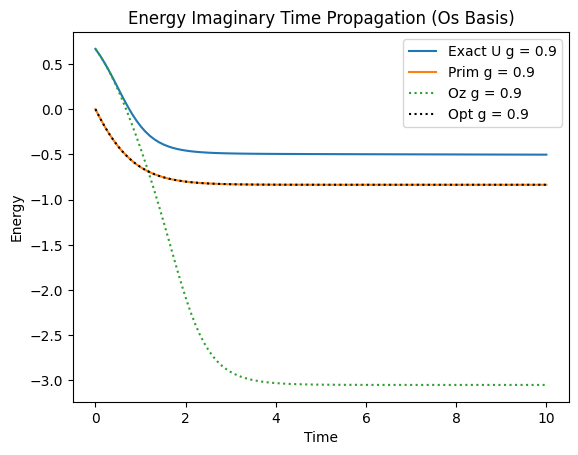

TF-Opt (-0.8360314278556055+0j)
TF (-0.836031427855606+0j)
Exact:  -0.5121301548272718


In [ ]:
plt.plot(time_TF, ED_U_val/site, label=f"Exact U g = {g}")
plt.plot(time_TF, -energy_TD_TF_CCC/site, label=f"Prim g = {g}")
plt.plot(time_TF_os, -energy_TD_TF_CCC_os/site, label=f"Oz g = {g}", linestyle=':')
plt.plot(time_opt, -energy_TD_CCC_opt/site, label=f"Opt g = {g}", linestyle=':', color = "black")
plt.title("Energy Imaginary Time Propagation (Os Basis)")
plt.xlabel("Time")
plt.ylabel("Energy")
plt.legend()
plt.show()

print("TF-Opt", -energy_TD_CCC_opt[-1]/site)
print("TF", -energy_TD_TF_CCC[-1]/site)
print("Exact: ", ground_ED/site)

In [ ]:
ground_ED

np.float64(-1.5363904644818154)

In [ ]:
ground_TF_os_ED

np.float64(-1.5363904644818187)

In [ ]:
ground_TF_ED

np.float64(-1.5363904644818194)

In [ ]:
ground_TF_opt_ED

np.float64(-1.53639046448182)